In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import os,sys
from PIL import Image
from helpers import *
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from pylab import *
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/mac/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
# Loaded a set of images
#root_dir = "augmented_training/"
root_dir = "training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)  

n = 100

print("Loading " + str(n) + " satellite images")
imgs = [load_image(image_dir + files[i]) for i in range(n)] #List of each image Dim (100, 400,400,3)

gt_dir = root_dir + "groundtruth/"
files2 = os.listdir(gt_dir)

print("Loading " + str(n) + " groundtruth images")
gt_imgs = [load_image(gt_dir + files2[i]) for i in range(n)]
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

Loading 100 satellite images
Loading 100 groundtruth images
Image size = 400,400


In [8]:
patch_size = 16 # each patch is 16*16 pixels  #400/16 = 25*25 = 625 patches for 10 images

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]   # dim img_patches = (n,625,16,16,3)
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches

X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print("img_patches:" + str(X.shape))
print("gt_patches:" + str(gt_patches.shape))

img_patches:(62500, 16, 16, 3)
gt_patches:(62500, 16, 16)


In [9]:
foreground_threshold = 0.25    
Y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold) for i in range(len(gt_patches))])
Y.shape

(62500,)

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1)

print("X_train:",X_train.shape)
print("X_val: ",X_val.shape)
print("Y_train",Y_train.shape)
print("Y_val",Y_val.shape)

X_train: (56250, 16, 16, 3)
X_val:  (6250, 16, 16, 3)
Y_train (56250,)
Y_val (6250,)


In [13]:
from keras.optimizers import Adam

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(16, 16, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0, nesterov=True)
opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer= opt, metrics = ['accuracy'])

network_history = model.fit(X_train, Y_train, batch_size=64, epochs=40, validation_data = (X_val,Y_val))
#network_history = model.fit(X, Y, batch_size=64, epochs=20)

score = model.evaluate(X_val, Y_val, batch_size=64)

Train on 56250 samples, validate on 6250 samples
Epoch 1/40
56250/56250 [==============================] - 59s 1ms/step - loss: 0.5179 - acc: 0.7466 - val_loss: 0.4651 - val_acc: 0.7694
Epoch 2/40
56250/56250 [==============================] - 57s 1ms/step - loss: 0.4463 - acc: 0.7830 - val_loss: 0.4159 - val_acc: 0.7989
Epoch 3/40
56250/56250 [==============================] - 57s 1ms/step - loss: 0.4236 - acc: 0.7984 - val_loss: 0.4044 - val_acc: 0.8067
Epoch 4/40
56250/56250 [==============================] - 58s 1ms/step - loss: 0.4138 - acc: 0.8041 - val_loss: 0.4032 - val_acc: 0.8069
Epoch 5/40
56250/56250 [==============================] - 58s 1ms/step - loss: 0.4019 - acc: 0.8105 - val_loss: 0.3852 - val_acc: 0.8205
Epoch 6/40
56250/56250 [==============================] - 61s 1ms/step - loss: 0.3958 - acc: 0.8135 - val_loss: 0.4062 - val_acc: 0.8098
Epoch 7/40
56250/56250 [==============================] - 61s 1ms/step - loss: 0.3897 - acc: 0.8174 - val_loss: 0.3822 - val_acc:

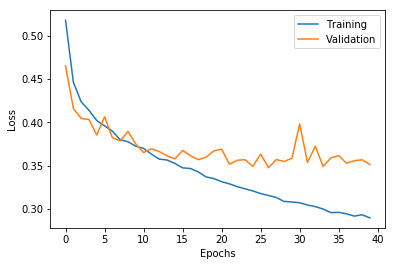

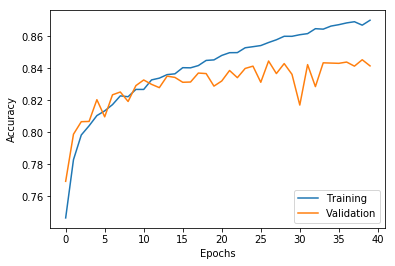

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

## SUBMISSION 


In [41]:
test_dir = 'test_set_images/'

imgs_test = load_test_images(test_dir) ##In helpers.py
patch_size = 16 

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(len(imgs_test))]# dim img_patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

print("img_patches:" + str(img_patches_test.shape))

data = np.asarray([extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])
print('Dataset (RGB features Mean/Variance) :', data.shape)


['test_set_images/test_1/test_1.png', 'test_set_images/test_2/test_2.png', 'test_set_images/test_3/test_3.png', 'test_set_images/test_4/test_4.png', 'test_set_images/test_5/test_5.png', 'test_set_images/test_6/test_6.png', 'test_set_images/test_7/test_7.png', 'test_set_images/test_8/test_8.png', 'test_set_images/test_9/test_9.png', 'test_set_images/test_10/test_10.png', 'test_set_images/test_11/test_11.png', 'test_set_images/test_12/test_12.png', 'test_set_images/test_13/test_13.png', 'test_set_images/test_14/test_14.png', 'test_set_images/test_15/test_15.png', 'test_set_images/test_16/test_16.png', 'test_set_images/test_17/test_17.png', 'test_set_images/test_18/test_18.png', 'test_set_images/test_19/test_19.png', 'test_set_images/test_20/test_20.png', 'test_set_images/test_21/test_21.png', 'test_set_images/test_22/test_22.png', 'test_set_images/test_23/test_23.png', 'test_set_images/test_24/test_24.png', 'test_set_images/test_25/test_25.png', 'test_set_images/test_26/test_26.png', 'te

In [66]:
y_pred = model.predict(img_patches_test, batch_size = 64)

In [67]:
for i in range(len(y_pred)):
    
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

print('prediction_shape: before',y_pred.shape)
labels = np.reshape(y_pred,(50,1444))
print('prediction_shape: after',labels.shape) ##iterate over each image more easily

prediction_shape: before (72200, 1)
prediction_shape: after (50, 1444)


In [68]:
imgwidth = imgs_test[0].shape[0] 
imgheight = imgs_test[0].shape[1] 
w = patch_size
h = patch_size

os.makedirs('prediction_cnnnn/', exist_ok=True) 

for i in range(len(labels)):
    im = label_to_img(imgwidth, imgheight, w, h, labels[i])
    im = img_float_to_uint8(im)
    Image.fromarray(im).save('prediction_cnnnn/prediction_' + '%.3d' % (i + 1)+ '.png')

[[1 2]
 [3 4]
 [5 6]]


400